In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime, timedelta
## Replace with your own path
sys.path.append('/Users/tarabaris/GitHub/odp-sdk-python/Examples')

## For SDK
import getpass
from odp_sdk import ODPClient
from getpass import getpass

from CastFunctions import *
## For plotting
import seaborn as sns
import matplotlib.pyplot as plt
import mpl_toolkits
import cmocean

## Extra functions
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_palette(sns.color_palette("bright", 47))
import warnings
warnings.filterwarnings("ignore")
import calendar

# Connect to API

In [4]:
client = ODPClient(api_key=getpass(prompt='Insert your personal ODP API key:'), 
                       project="odp", client_name="odp")

Insert your personal ODP API key:········


# Pull data for desired lat/long and timespan
Don't forget to specify if you want flagged data included or excluded

In [33]:
df=client.casts(longitude=[-10,35],
                latitude=[50,80],
                timespan=['2015-01-01','2018-12-31'],
                n_threads=35) 

Locating available casts..
-> 82097 casts found
-> 10632104 data rows downloaded in 1816.27s


# Let's explore the data

In [35]:
df2=df[(df['Temperature_WODflag']==0) & (df.z<50)][['externalId','lon','lat','z','datetime','Temperature']].dropna()

In [36]:
df2.head()

,externalId,lon,lat,z,datetime,Temperature
0,cast_wod_3_2015_35259_17376615,15.22,68.98,4.0,2015-12-19,7.55
1,cast_wod_3_2015_35259_17376615,15.22,68.98,5.0,2015-12-19,7.55
2,cast_wod_3_2015_35259_17376615,15.22,68.98,6.0,2015-12-19,7.55
3,cast_wod_3_2015_35259_17376615,15.22,68.98,7.0,2015-12-19,7.54
4,cast_wod_3_2015_35259_17376615,15.22,68.98,8.0,2015-12-19,7.54


In [37]:
df_surf=interpolate_casts_to_z(df2,'Temperature',[0,10,20])

In [39]:
df_surf.head()

,externalId,datetime,lon,lat,z,Temperature
0,cast_wod_3_2015_35259_17376615,2015-12-19,15.22,68.98,0.0,NaN
1,cast_wod_3_2015_35259_17376615,2015-12-19,15.22,68.98,10.0,7.540000
2,cast_wod_3_2015_35259_17376615,2015-12-19,15.22,68.98,20.0,NaN
3,cast_wod_3_2015_31281_17121983,2015-08-21,-6.39,50.50,0.0,16.469999
4,cast_wod_3_2015_31281_17121983,2015-08-21,-6.39,50.50,10.0,NaN


In [40]:
df_surf['unixtime']=df_surf['datetime'].apply(lambda x : x.value) 
df_surf.dropna(inplace=True)
df_surf=df_surf[df_surf.Temperature>-1]
df_surf.describe()

,lon,lat,z,Temperature,unixtime
count,185053.000000,185053.000000,185053.000000,185053.000000,1.850530e+05
mean,7.248878,60.240086,10.194701,9.586701,1.488712e+18
std,9.971517,7.442931,7.962679,4.778113,3.589436e+16
min,-9.999333,50.000830,0.000000,-1.000000,1.420157e+18
25%,-0.831667,55.320000,0.000000,5.894000,1.460160e+18
50%,8.382667,57.325800,10.000000,9.238696,1.495152e+18
75%,14.559167,62.018000,20.000000,13.300000,1.521418e+18
max,34.986000,79.999664,20.000000,25.802584,1.546128e+18


# Plot temperature over months

,month,North Sea,Barents Sea,Baltic Sea
0,January,7.364733,2.750277,4.334331
1,February,7.028915,5.583226,4.103400
2,March,5.351347,2.570641,2.637639
3,April,6.077198,2.176115,3.352534
4,May,8.790373,5.406427,6.474589
5,June,13.074521,5.930183,12.816195
6,July,15.443251,7.038476,16.443784
7,August,17.379251,9.053936,16.299361
8,September,16.548640,7.383399,15.694856
9,October,12.328609,7.659250,11.516855


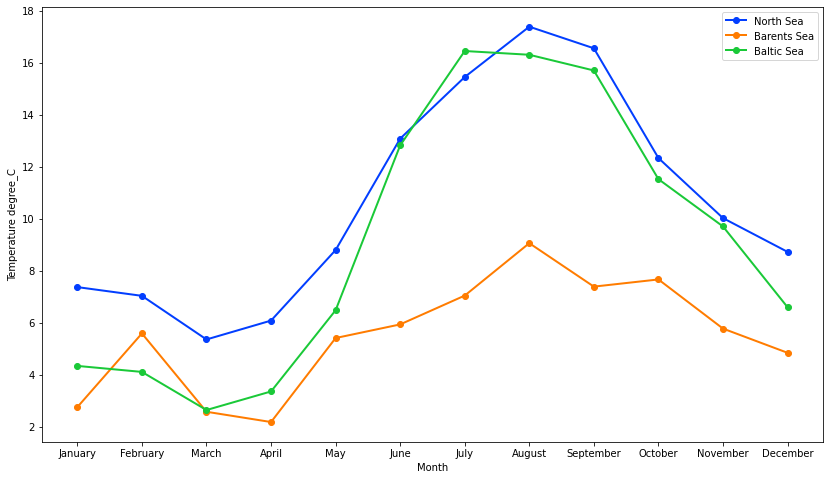

In [57]:
## Pick a year
df_2018 = df_surf[df_surf.datetime.dt.year == 2018]
coord = {
'month':[1,2,3,4,5,6,7,8,9,10,11,12],
'lat':[56,73,56],
'lon':[3, 20, 18],
'name':['North Sea','Barents Sea','Baltic Sea']}
kind = 'rbf'


temp = []
for mnth in coord['month']:
    try:
        points=df_2018[df_2018.datetime.dt.month == mnth][['lon','lat']].values.astype('float')
        values=df_2018[df_2018.datetime.dt.month == mnth]['Temperature'].values.astype('float')
        int_points=[coord['lon'], coord['lat']]
        grid,g=inerpolate_to_grid(points.copy(),values.copy(),int_points.copy(), interp_type=kind,
                               rbf_func='linear',rbf_smooth=0.1,rescale=True)
        
    except:
        g=None
    temp.append(g)
    
df_temp = pd.DataFrame({
                    'month': [calendar.month_name[mnth] for mnth in coord['month']]})

temp_values = []
for i in range(len(coord['month'])):
    temp_values.append(temp[i].diagonal())

for name in coord['name']:
    temp_values = np.vstack(temp_values)
    df_temp[name] = temp_values[:,coord['name'].index(name)]
    
colors = sns.color_palette('bright')
plt.figure(figsize=(14,8))

for i, name in enumerate(coord['name']):
    plt.plot( 'month', name, data=df_temp, marker='o',color=colors[i], linewidth=2)
    plt.xlabel('Month')
    plt.ylabel('Temperature {}'.format(get_units()['Temperature']))
    plt.legend()
    
df_temp


# Plot seasonal temperatuer over years

In [58]:
seasons = ['Winter', 'Winter', 'Winter', 'Spring', 'Spring', 'Spring','Summer', 'Summer','Summer','Fall', 'Fall', 'Fall', ]
month_to_season = dict(zip(range(1,13), seasons))

df_surf['season'] = df_surf.datetime.dt.month.map(month_to_season)

df_surf.head()

,externalId,datetime,lon,lat,z,Temperature,unixtime,season
1,cast_wod_3_2015_35259_17376615,2015-12-19,15.220,68.98,10.0,7.540000,1450483200000000000,Fall
3,cast_wod_3_2015_31281_17121983,2015-08-21,-6.390,50.50,0.0,16.469999,1440115200000000000,Summer
6,cast_wod_3_2015_31281_17121996,2015-08-22,-6.377,50.49,0.0,16.480000,1440201600000000000,Summer
9,cast_wod_3_2015_31281_17122032,2015-08-22,-6.342,50.53,0.0,16.830000,1440201600000000000,Summer
12,cast_wod_3_2015_31281_17122048,2015-08-22,-6.306,50.55,0.0,16.459999,1440201600000000000,Summer


,year,North Sea,Barents Sea,Baltic Sea
0,2015,15.542477,8.835994,15.120701
1,2016,15.201867,8.613310,16.987446
2,2017,16.109360,8.733190,15.307017
3,2018,16.593198,8.478157,15.515344


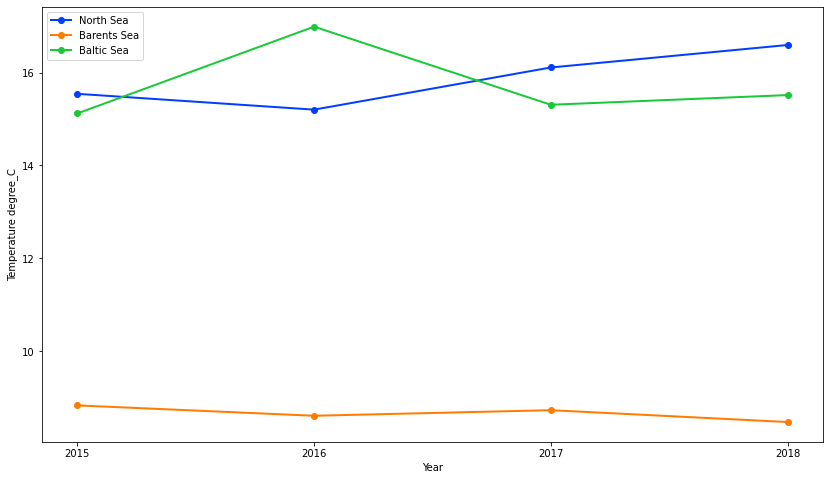

In [59]:
season = 'Summer'
df_season = df_surf[df_surf.season == season]

coord = {
'year':[2015, 2016, 2017, 2018],
'lat':[56,73,56],
'lon':[3, 20, 18],
'name':['North Sea','Barents Sea','Baltic Sea']}
kind = 'rbf'


temp = []
for yr in coord['year']:
    try:
        points=df_season[df_season.datetime.dt.year == yr][['lon','lat']].values.astype('float')
        values=df_season[df_season.datetime.dt.year == yr]['Temperature'].values.astype('float')
        int_points=[coord['lon'], coord['lat']]
        grid,g=inerpolate_to_grid(points.copy(),values.copy(),int_points.copy(), interp_type=kind,
                               rbf_func='linear',rbf_smooth=0.1,rescale=True)
        
    except:
#         print(mnth)
        g=None
    temp.append(g)
    
df_temp = pd.DataFrame({
                    'year': coord['year']})

temp_values = []
for i in range(len(coord['year'])):
    temp_values.append(temp[i].diagonal())

for name in coord['name']:
    temp_values = np.vstack(temp_values)
    df_temp[name] = temp_values[:,coord['name'].index(name)]
    
colors = sns.color_palette('bright')
plt.figure(figsize=(14,8))

for i, name in enumerate(coord['name']):
    plt.plot( 'year', name, data=df_temp, marker='o',color=colors[i], linewidth=2)
    plt.xlabel('Year')
    plt.xticks(coord['year'])
    plt.ylabel('Temperature {}'.format(get_units()['Temperature']))
    plt.legend()
    
df_temp


# Plot individual casts with depth

Text(0.5, 0, 'Temperature degree_C')

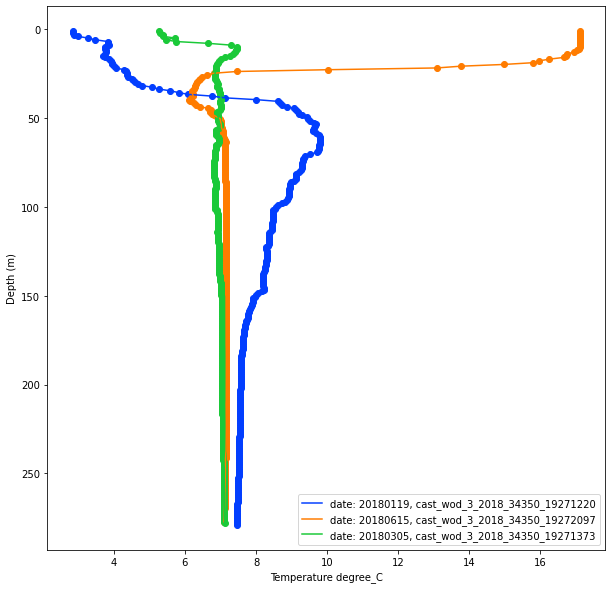

In [22]:
cast_names=['cast_wod_3_2018_34350_19271220','cast_wod_3_2018_34350_19272097','cast_wod_3_2018_34350_19271373']
variable='Temperature'

plt.figure(figsize=(10,10))
legend=[]
for cast_name in cast_names:
    data=client.download_data_from_casts([cast_name])
    plt.plot(data[variable],data.z)
    plt.scatter(data[variable],data.z)
    legend.append('date: {}, {}'.format(data.date.iloc[0],cast_name))

plt.legend(legend,loc=0)
plt.gca().invert_yaxis()   
plt.ylabel('Depth (m)')
plt.xlabel(variable + ' ' + get_units()[variable])
